<a href="https://colab.research.google.com/github/SH22Hwang/KoGES_OP/blob/master/OP_20230921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 골다공증

다양한 모델로 돌려보았다~

- Traditional ML
  + KNN
  + Decison Tree
  + SVM <- 공부 좀 해야할 듯
- GBDT
  + XGBoost
  + LGBM
- DNN
  + MLP

## 총 정리

- 각 데이터 별로 나눠서 돌리기
  - 폐경 전
  - 폐경 후
  - 둘 다

  - 식이패턴만
  - 유전체만
  - 둘 다

- 전처리 / 증강은 X_train만 할 것

- SVM도 잘 만들어볼 것...?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, roc_auc_score # roc_auc_score(y_test, y_pred)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
import lightgbm as lgb

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 불러오기
# _all: 폐경 전 후 snp까지 모두

X_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/X_231005.csv', index_col=0)
y_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/y_231005.csv', index_col=0)

y_premeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_premeno_20230821.csv', index_col=0)
y_postmeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_postmeno_20230821.csv', index_col=0)

var_to_use = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/var_to_use_2023-06-13T1650I.csv')

In [ ]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4093 entries, NIH2307713334 to NIH2307534318
Columns: 140 entries, AS1_SEX to SNP_A-2242511
dtypes: float64(127), object(13)
memory usage: 4.4+ MB


## 데이터 불러오기

- train set: 0.8
  - train set: 0.64
  - val set: 0.16
- test set: 0.2

[참고 자료](https://ysyblog.tistory.com/69)


- 데이터셋 만들 수 있는 경우의 수 총 9개
  1. 폐경 전 / 식이패턴 있음, 유전체 없음
  2. 폐경 후 / 식이패턴 있음, 유전체 없음
  3. 모두 / 식이패턴 있음, 유전체 없음
  4. 폐경 전 / 식이패턴 없음, 유전체 있음
  5. 폐경 후 / 식이패턴 없음, 유전체 있음
  6. 모두 / 식이패턴 없음, 유전체 있음
  7. 폐경 전 / 식이패턴 있음, 유전체 있음
  8. 폐경 후 / 식이패턴 있음, 유전체 있음
  9. 모두 / 식이패턴 있음, 유전체 있음

In [ ]:
# Statistical Accuracy Measurement Comprehensive Gift Set
def SAMCGS(y_test, y_pred):
  # 정확도 종합 선물 세트
  accuracy = accuracy_score(y_test, y_pred)
  conf_mat = confusion_matrix(y_test, y_pred)
  # [[TP  FN]
  # [ FP  TN]]

  precision = precision_score(y_test, y_pred, zero_division=1) # tp / (tp + fp)
  recall = recall_score(y_test, y_pred, zero_division=1)       # tp / (tp + fn)
  f1 = f1_score(y_test, y_pred, zero_division=1) # 2 * (precision * recall) / (precision + recall)

  print(f'''
  Confusion Matrix:\n{conf_mat}\n
  [[TP  FN]
  [ FP  TN]]

  Accuracy: {accuracy:.3f}
  Precison: {precision:.3f}
  Recall  : {recall:.3f}
  F1 Score: {f1:.3f}'''
  )

  # return precision, recall, f1

In [ ]:
quantile_transformer = QuantileTransformer(random_state=415)
norm = Normalizer()
# scaler = StandardScaler()

smt = SMOTE(random_state=415)
rus = RandomUnderSampler(random_state=415)

In [ ]:
def split_ttv(x, y):
  # 전체 다 하기?
  # x = pd.DataFrame(quantile_transformer.fit_transform(x), index=x.index, columns=x.columns).astype('float')
  x = pd.DataFrame(norm.fit_transform(x).astype('float'))

  # train : test == 4 : 1
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415) # stratify: target의 class비율에 맞춰서 분리

  # train 증강, test, val 컷
  x_train, y_train = smt.fit_resample(x_train, y_train)

  # train : val == 4 : 1
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=415)

  # 각각 하기...?
  # x_train = pd.DataFrame(quantile_transformer.fit_transform(x_train), index=x_train.index, columns=x_train.columns).astype('float')
  # x_test = pd.DataFrame(quantile_transformer.transform(x_test), index=x_test.index, columns=x_test.columns).astype('float')
  # x_val = pd.DataFrame(quantile_transformer.transform(x_val), index=x_val.index, columns=x_val.columns).astype('float')

  # 다른 걸로 바꿔보기..?
  # x_train = pd.DataFrame(norm.fit_transform(x_train).astype('float'))
  # x_test = pd.DataFrame(norm.transform(x_test).astype('float'))
  # x_val = pd.DataFrame(norm.transform(x_val).astype('float'))


  x_test, y_test = rus.fit_resample(x_test, y_test)
  # x_val, y_val = rus.fit_resample(x_val, y_val)

  return x_train, x_test, x_val, y_train, y_test, y_val

def split_tt(x, y):
  # 전체 다 하기?
  # x = pd.DataFrame(quantile_transformer.fit_transform(x), index=x.index, columns=x.columns).astype('float')
  x = pd.DataFrame(norm.fit_transform(x).astype('float'))

  # train : test == 4 : 1
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415) # stratify: target의 class비율에 맞춰서 분리

  # # 각각 하기?
  # x_train = pd.DataFrame(quantile_transformer.fit_transform(x_train), index=x_train.index, columns=x_train.columns).astype('float')
  # x_test = pd.DataFrame(quantile_transformer.transform(x_test), index=x_test.index, columns=x_test.columns).astype('float')

  # 다른 걸로 바꿔보기..?
  # x_train = pd.DataFrame(norm.fit_transform(x_train).astype('float'))
  # x_test = pd.DataFrame(norm.transform(x_test).astype('float'))

  # train 증강, test 컷
  x_train, y_train = smt.fit_resample(x_train, y_train)
  x_test, y_test = rus.fit_resample(x_test, y_test)

  return x_train, x_test, y_train, y_test


# 9가지 경우의 수에 맞게 데이터 돌림

meno1 = X_all['AS1_PMYN_C'] == 1
meno2 = X_all['AS1_PMYN_C'] == 2
snp = pd.Series(['SNP_A-2181021', 'SNP_A-1809518', 'SNP_A-2130710', 'SNP_A-2263153',
                 'SNP_A-2310995', 'SNP_A-1922415', 'SNP_A-2266073', 'SNP_A-1984271',
                 'SNP_A-2218697', 'SNP_A-1850320', 'SNP_A-4262878', 'SNP_A-4299800',
                 'SNP_A-2242511'])

onehot = pd.concat([var_to_use['cath0'].dropna(), snp], ignore_index=True)

In [ ]:
# 1. 폐경 전 / 식이패턴 있음, 유전체 없음
# x = X_all.drop(snp, axis=1)
# x = pd.get_dummies(x.loc[meno1], columns=var_to_use['cath0'].dropna(), drop_first=True, dtype='float64')
# y = y_premeno
# f1score 거의 0

# 2. 폐경 후 / 식이패턴 있음, 유전체 없음
x = X_all.drop(snp, axis=1)
x = pd.get_dummies(x.loc[meno2], columns=var_to_use['cath0'].dropna(), dtype='float64')
y = y_postmeno

# 3. 모두 / 식이패턴 있음, 유전체 없음
# x = X_all.drop(snp, axis=1)
# x = pd.get_dummies(X_all, columns=onehot, drop_first=True, dtype='float64')
# y = y_all

# 4, 5, 6 생략

# 7. 폐경 전 / 식이패턴 있음, 유전체 있음
# x = pd.get_dummies(X_all.loc[meno1], columns=onehot, drop_first=True, dtype='float64')
# y = y_premeno
# f1score 거의 0

# # 8 폐경 후 / 식이패턴 있음, 유전체 있음
# x = pd.get_dummies(X_all.loc[meno2], columns=onehot, drop_first=True, dtype='float64')
# y = y_postmeno
##### 정확도 매우 떨어짐

# # 9 모두 / 식이패턴 없음, 유전체 있음
# x = pd.get_dummies(X_all, columns=onehot, drop_first=True, dtype='float64')
# y = y_all

In [ ]:
var_to_use['cath1'].dropna()

0     AS1_INCOME
1     AS1_PHYSTB
2     AS1_PHYSIT
3    AS1_PHYACTL
4    AS1_PHYACTM
5    AS1_PHYACTH
6    AS1_ICOFF_1
Name: cath1, dtype: object

In [ ]:
pd.set_option('display.max_seq_items', None)
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2567 entries, NIH2307137554 to NIH2307534318
Columns: 143 entries, AS1_SEX to AS1_OVARYW_3.0
dtypes: float64(143)
memory usage: 2.8+ MB


## Decision Tree

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
X_train, X_test, y_train, y_test = split_tt(x, y)

In [ ]:
# Defining the hyper parameters
hps = {
    'max_depth': 7,
    'min_samples_split': 2
}

# Loading the tree object
tree = DecisionTreeClassifier(**hps)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [ ]:
y_pred = tree.predict(X_test)

SAMCGS(y_test, y_pred)


  Confusion Matrix:
[[103  41]
 [ 73  71]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.604
  Precison: 0.634
  Recall  : 0.493
  F1 Score: 0.555


### 그래프

In [ ]:
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 4
}

# Loading the tree object
tree = DecisionTreeClassifier(**hps)

tree.fit(x, y)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [ ]:
export_graphviz(tree, out_file="tree.dot",
                class_names='FT',
                feature_names=x.columns,
                impurity=True, filled=True)

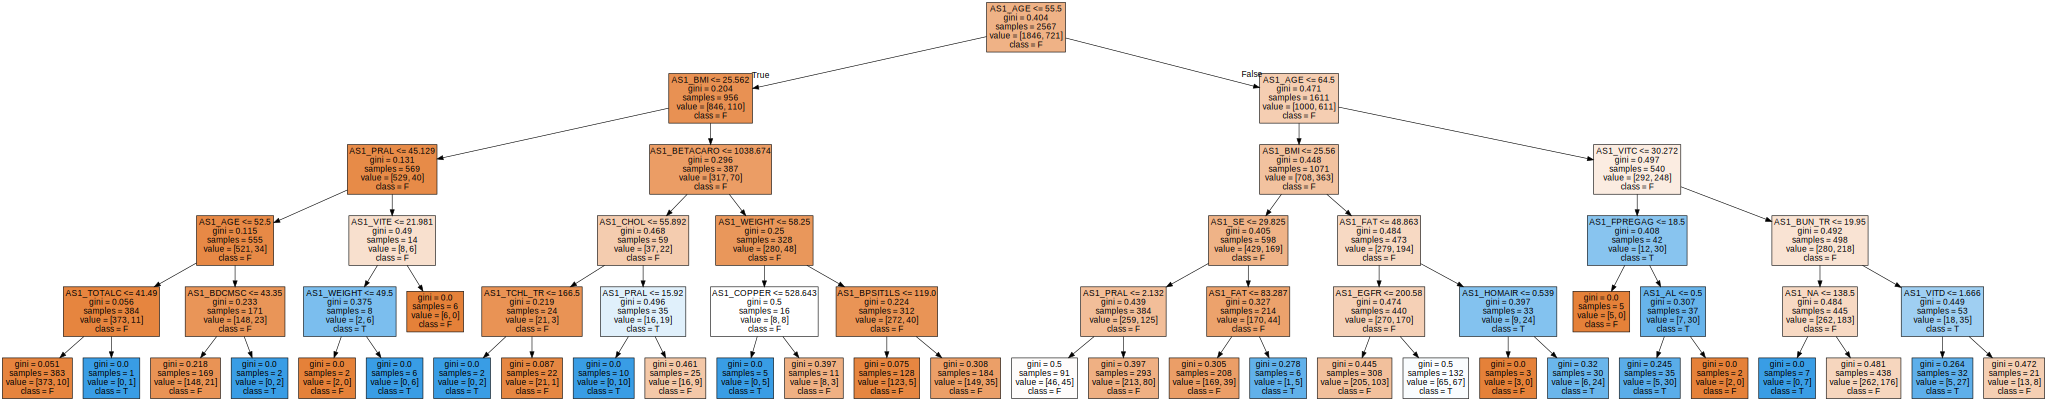

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph, filename='tree.png',format='png')

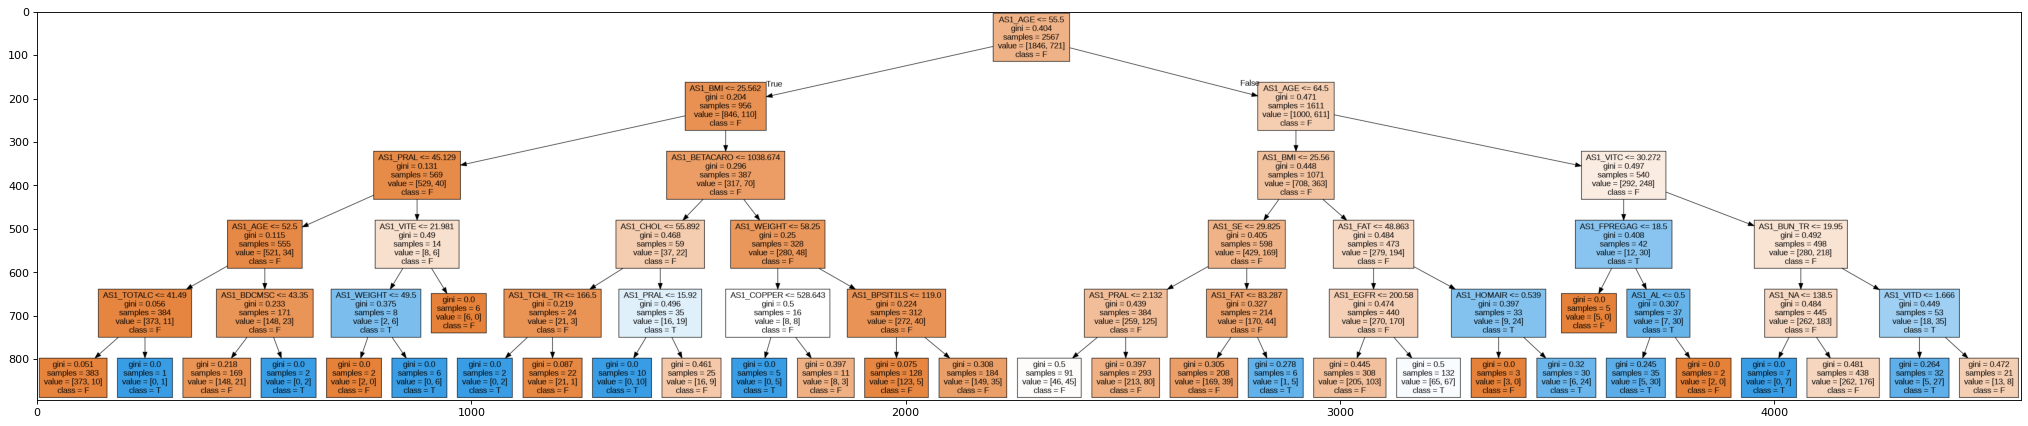

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

### importance

In [ ]:
# Extracting the importances by sklearn
importances_sk = tree.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(X_test.columns.tolist()):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")

Feature importance by sklearn: {'AS1_SEX': 0.0, 'AS1_HT': 0.0, 'AS1_DM': 0.0, 'AS1_AL': 0.013, 'AS1_MI': 0.0, 'AS1_TH': 0.0, 'AS1_CH': 0.0, 'AS1_CD': 0.0, 'AS1_LP': 0.0, 'AS1_AS': 0.0, 'AS1_CL': 0.0, 'AS1_KD': 0.0, 'AS1_CV': 0.0, 'AS1_GT': 0.0, 'AS1_ARRM': 0.0, 'AS1_DRST': 0.0, 'AS1_DRCP': 0.0, 'AS1_DRINS': 0.0, 'AS1_DRHT': 0.0, 'AS1_DRAR': 0.0, 'AS1_DRTH': 0.0, 'AS1_DRFH': 0.0, 'AS1_DROS': 0.0, 'AS1_DRSTK': 0.0, 'AS1_DRAS': 0.0, 'AS1_DRLP': 0.0, 'AS1_DRSP': 0.0, 'AS1_DRSL': 0.0, 'AS1_PMYN_C': 0.0, 'AS1_PREG': 0.0, 'AS1_HYST': 0.0, 'AS1_OBGYOP': 0.0, 'AS1_BRCA': 0.0, 'AS1_BRSTF': 0.0, 'AS1_INSM': 0.0, 'AS1_SLPHRD': 0.0, 'AS1_INCOME': 0.0, 'AS1_PHYSTB': 0.0, 'AS1_PHYSIT': 0.0, 'AS1_PHYACTL': 0.0, 'AS1_PHYACTM': 0.0, 'AS1_PHYACTH': 0.0, 'AS1_ICOFF_1': 0.0, 'AS1_AGE': 0.441, 'AS1_TOTALC': 0.009, 'AS1_PMAG_C': 0.0, 'AS1_MNSAG': 0.0, 'AS1_CHILD_P': 0.0, 'AS1_FPREGAG': 0.026, 'AS1_SLPAMTM': 0.0, 'AS1_ENERGY': 0.0, 'AS1_CARBO': 0.0, 'AS1_FAT': 0.055, 'AS1_PROTEIN': 0.0, 'AS1_FIBER': 0.0, 'AS1

Text(0, 0.5, 'feature importance')

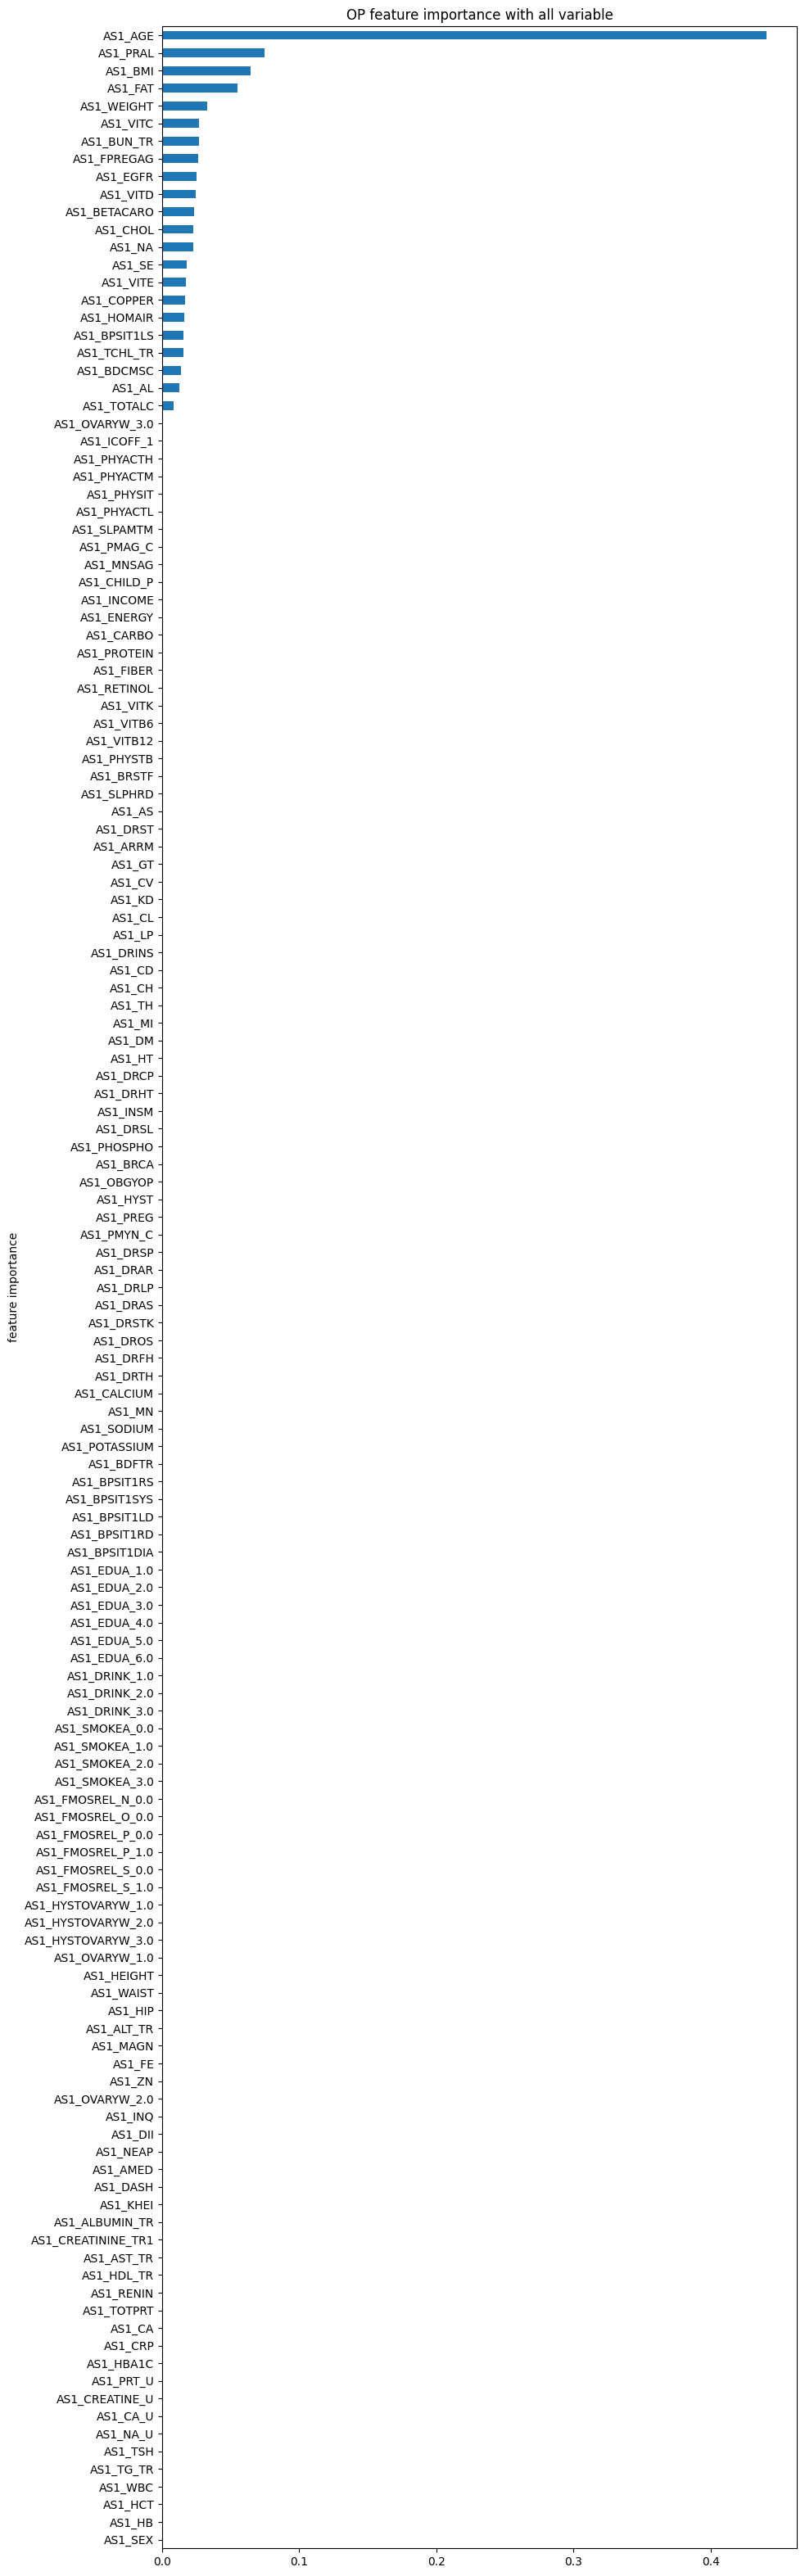

In [ ]:
importances = tree.feature_importances_

tree_importances = pd.Series(importances, index=X_test.columns).sort_values()
fig, ax = plt.subplots(figsize=(10, 40))
tree_importances.plot.barh(ax=ax)
ax.set_title("OP feature importance with all variable")
ax.set_ylabel("feature importance")

In [ ]:
tree_importances

AS1_SEX       0.000000
AS1_HB        0.000000
AS1_HCT       0.000000
AS1_WBC       0.000000
AS1_TG_TR     0.000000
                ...   
AS1_WEIGHT    0.032819
AS1_FAT       0.054641
AS1_BMI       0.064771
AS1_PRAL      0.074435
AS1_AGE       0.440793
Length: 143, dtype: float64

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
SAMCGS(y_test, y_pred)


  Confusion Matrix:
[[82 62]
 [61 83]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.573
  Precison: 0.572
  Recall  : 0.576
  F1 Score: 0.574


## SVM

In [ ]:
X_train, X_test, y_train, y_test = split_tt(x, y)

X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [ ]:
# Define the linear SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
svm = SVM(X_train.shape[1])

# Define the loss function and optimizer
criterion = nn.HingeEmbeddingLoss()
optimizer = optim.SGD(svm.parameters(), lr=0.01)


In [ ]:
# Train the model
for epoch in range(100):
    # output = svm(X_train_tensor).squeeze()
    output = svm(X_train_tensor)

    loss = criterion(output, 2 * y_train_tensor.float()-1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Make predictions on the test set
y_pred = torch.sign(svm(X_test_tensor).squeeze()).detach().numpy()

In [ ]:
y_pred = np.where(y_pred < 0, 0, 1)
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 86, 1: 202}


In [ ]:
SAMCGS(y_test, y_pred)


  Confusion Matrix:
[[ 38 106]
 [ 48  96]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.465
  Precison: 0.475
  Recall  : 0.667
  F1 Score: 0.555


## XGBoost

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = split_ttv(x, y)

X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
X_val_tensor = torch.tensor(X_val.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
y_test_tensor = torch.tensor(y_test.values).float()
y_val_tensor = torch.tensor(y_val.values).float()

In [ ]:
from sklearn.model_selection import GridSearchCV

# create model instance
xgb = XGBClassifier(n_estimators=1000, # 나무의 개수
                    learning_rate=0.01,
                    objective='binary:logistic',
                    silent=1)

# 후보 파라미터 선정
params = {'max_depth':[3, 8], 'min_child_weight':[1, 3], 'colsample_bytree':[0,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb, param_grid=params, cv=3)

gridcv.fit(X_train, y_train,
           early_stopping_rounds=30,
           eval_metric='aucpr', # auc -> aucpr
           eval_set=[(X_val, y_val)])

[0]	validation_0-aucpr:0.55074
[1]	validation_0-aucpr:0.57123
[2]	validation_0-aucpr:0.56744
[3]	validation_0-aucpr:0.56979
[4]	validation_0-aucpr:0.56520
[5]	validation_0-aucpr:0.57000
[6]	validation_0-aucpr:0.56033
[7]	validation_0-aucpr:0.55414


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:46:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:0.55546
[9]	validation_0-aucpr:0.55319
[10]	validation_0-aucpr:0.53263
[11]	validation_0-aucpr:0.53992
[12]	validation_0-aucpr:0.58184
[13]	validation_0-aucpr:0.58935
[14]	validation_0-aucpr:0.59207
[15]	validation_0-aucpr:0.58670
[16]	validation_0-aucpr:0.58221
[17]	validation_0-aucpr:0.58916
[18]	validation_0-aucpr:0.58378
[19]	validation_0-aucpr:0.57674
[20]	validation_0-aucpr:0.57051
[21]	validation_0-aucpr:0.57194
[22]	validation_0-aucpr:0.57038
[23]	validation_0-aucpr:0.57683
[24]	validation_0-aucpr:0.57491
[25]	validation_0-aucpr:0.57824
[26]	validation_0-aucpr:0.58282
[27]	validation_0-aucpr:0.58536
[28]	validation_0-aucpr:0.58383
[29]	validation_0-aucpr:0.58801
[30]	validation_0-aucpr:0.60911
[31]	validation_0-aucpr:0.61113
[32]	validation_0-aucpr:0.60647
[33]	validation_0-aucpr:0.60505
[34]	validation_0-aucpr:0.61144
[35]	validation_0-aucpr:0.61144
[36]	validation_0-aucpr:0.61152
[37]	validation_0-aucpr:0.61085
[38]	validation_0-aucpr:0.61301
[39]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:46:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-aucpr:0.55695
[11]	validation_0-aucpr:0.56908
[12]	validation_0-aucpr:0.60319
[13]	validation_0-aucpr:0.60103
[14]	validation_0-aucpr:0.59209
[15]	validation_0-aucpr:0.59535
[16]	validation_0-aucpr:0.59106
[17]	validation_0-aucpr:0.59023
[18]	validation_0-aucpr:0.59095
[19]	validation_0-aucpr:0.59231
[20]	validation_0-aucpr:0.59120
[21]	validation_0-aucpr:0.59304
[22]	validation_0-aucpr:0.59463
[23]	validation_0-aucpr:0.59353
[24]	validation_0-aucpr:0.58728
[25]	validation_0-aucpr:0.58616
[26]	validation_0-aucpr:0.58338
[27]	validation_0-aucpr:0.58356
[28]	validation_0-aucpr:0.57322
[29]	validation_0-aucpr:0.57931
[30]	validation_0-aucpr:0.60409
[31]	validation_0-aucpr:0.60640
[32]	validation_0-aucpr:0.60608
[33]	validation_0-aucpr:0.60792
[34]	validation_0-aucpr:0.61338
[35]	validation_0-aucpr:0.61171
[36]	validation_0-aucpr:0.61316
[37]	validation_0-aucpr:0.61481
[38]	validation_0-aucpr:0.61412
[39]	validation_0-aucpr:0.61412
[40]	validation_0-aucpr:0.61009
[41]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.55236
[1]	validation_0-aucpr:0.57340
[2]	validation_0-aucpr:0.56485
[3]	validation_0-aucpr:0.55373
[4]	validation_0-aucpr:0.53989
[5]	validation_0-aucpr:0.54577
[6]	validation_0-aucpr:0.55838
[7]	validation_0-aucpr:0.55323
[8]	validation_0-aucpr:0.55313
[9]	validation_0-aucpr:0.55444
[10]	validation_0-aucpr:0.54695
[11]	validation_0-aucpr:0.55411
[12]	validation_0-aucpr:0.59171
[13]	validation_0-aucpr:0.59036
[14]	validation_0-aucpr:0.58951


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:46:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-aucpr:0.58685
[16]	validation_0-aucpr:0.58543
[17]	validation_0-aucpr:0.58024
[18]	validation_0-aucpr:0.57502
[19]	validation_0-aucpr:0.56823
[20]	validation_0-aucpr:0.56356
[21]	validation_0-aucpr:0.56489
[22]	validation_0-aucpr:0.56515
[23]	validation_0-aucpr:0.56957
[24]	validation_0-aucpr:0.57338
[25]	validation_0-aucpr:0.57480
[26]	validation_0-aucpr:0.57073
[27]	validation_0-aucpr:0.56923
[28]	validation_0-aucpr:0.57059
[29]	validation_0-aucpr:0.57768
[30]	validation_0-aucpr:0.60015
[31]	validation_0-aucpr:0.60128
[32]	validation_0-aucpr:0.59613
[33]	validation_0-aucpr:0.59520
[34]	validation_0-aucpr:0.59988
[35]	validation_0-aucpr:0.59903
[36]	validation_0-aucpr:0.59959
[37]	validation_0-aucpr:0.59700
[38]	validation_0-aucpr:0.59865
[39]	validation_0-aucpr:0.59865
[40]	validation_0-aucpr:0.59879
[41]	validation_0-aucpr:0.59769
[42]	validation_0-aucpr:0.59658
[43]	validation_0-aucpr:0.59789
[44]	validation_0-aucpr:0.59868
[45]	validation_0-aucpr:0.59989
[46]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:46:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.57162
[2]	validation_0-aucpr:0.55851
[3]	validation_0-aucpr:0.56269
[4]	validation_0-aucpr:0.56037
[5]	validation_0-aucpr:0.56546
[6]	validation_0-aucpr:0.55959
[7]	validation_0-aucpr:0.55439
[8]	validation_0-aucpr:0.55498
[9]	validation_0-aucpr:0.54494
[10]	validation_0-aucpr:0.52788
[11]	validation_0-aucpr:0.53883
[12]	validation_0-aucpr:0.58137
[13]	validation_0-aucpr:0.58302
[14]	validation_0-aucpr:0.58302
[15]	validation_0-aucpr:0.57549
[16]	validation_0-aucpr:0.56796
[17]	validation_0-aucpr:0.58255
[18]	validation_0-aucpr:0.57654
[19]	validation_0-aucpr:0.56834
[20]	validation_0-aucpr:0.55516
[21]	validation_0-aucpr:0.55707
[22]	validation_0-aucpr:0.55688
[23]	validation_0-aucpr:0.56315
[24]	validation_0-aucpr:0.56758
[25]	validation_0-aucpr:0.56792
[26]	validation_0-aucpr:0.57668
[27]	validation_0-aucpr:0.57485
[28]	validation_0-aucpr:0.57339
[29]	validation_0-aucpr:0.57764
[30]	validation_0-aucpr:0.59837
[31]	validation_0-aucpr:0.59837
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.55490
[1]	validation_0-aucpr:0.57772
[2]	validation_0-aucpr:0.57917
[3]	validation_0-aucpr:0.57306
[4]	validation_0-aucpr:0.56030
[5]	validation_0-aucpr:0.55315
[6]	validation_0-aucpr:0.55781
[7]	validation_0-aucpr:0.55314
[8]	validation_0-aucpr:0.55254
[9]	validation_0-aucpr:0.55284
[10]	validation_0-aucpr:0.55621
[11]	validation_0-aucpr:0.56369
[12]	validation_0-aucpr:0.59804
[13]	validation_0-aucpr:0.60021
[14]	validation_0-aucpr:0.60261


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:46:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-aucpr:0.60275
[16]	validation_0-aucpr:0.60081
[17]	validation_0-aucpr:0.59979
[18]	validation_0-aucpr:0.60260
[19]	validation_0-aucpr:0.60112
[20]	validation_0-aucpr:0.60072
[21]	validation_0-aucpr:0.60231
[22]	validation_0-aucpr:0.60414
[23]	validation_0-aucpr:0.60395
[24]	validation_0-aucpr:0.59650
[25]	validation_0-aucpr:0.59296
[26]	validation_0-aucpr:0.58971
[27]	validation_0-aucpr:0.58939
[28]	validation_0-aucpr:0.58115
[29]	validation_0-aucpr:0.58868
[30]	validation_0-aucpr:0.61386
[31]	validation_0-aucpr:0.61439
[32]	validation_0-aucpr:0.61277
[33]	validation_0-aucpr:0.61432
[34]	validation_0-aucpr:0.61526
[35]	validation_0-aucpr:0.61582
[36]	validation_0-aucpr:0.61578
[37]	validation_0-aucpr:0.61646
[38]	validation_0-aucpr:0.61725
[39]	validation_0-aucpr:0.61725
[40]	validation_0-aucpr:0.61284
[41]	validation_0-aucpr:0.61164
[42]	validation_0-aucpr:0.61342
[43]	validation_0-aucpr:0.61565
[44]	validation_0-aucpr:0.61974
[45]	validation_0-aucpr:0.62449
[46]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-aucpr:0.58006
[19]	validation_0-aucpr:0.57304
[20]	validation_0-aucpr:0.56663
[21]	validation_0-aucpr:0.56915
[22]	validation_0-aucpr:0.56811
[23]	validation_0-aucpr:0.57307
[24]	validation_0-aucpr:0.57533
[25]	validation_0-aucpr:0.57477
[26]	validation_0-aucpr:0.57130
[27]	validation_0-aucpr:0.56816
[28]	validation_0-aucpr:0.56642
[29]	validation_0-aucpr:0.57354
[30]	validation_0-aucpr:0.59468
[31]	validation_0-aucpr:0.59468
[32]	validation_0-aucpr:0.58908
[33]	validation_0-aucpr:0.58722
[34]	validation_0-aucpr:0.59327
[35]	validation_0-aucpr:0.59276
[36]	validation_0-aucpr:0.59287
[37]	validation_0-aucpr:0.59040
[38]	validation_0-aucpr:0.59152
[39]	validation_0-aucpr:0.59152
[40]	validation_0-aucpr:0.59355
[41]	validation_0-aucpr:0.59261
[0]	validation_0-aucpr:0.55911
[1]	validation_0-aucpr:0.57938
[2]	validation_0-aucpr:0.61634
[3]	validation_0-aucpr:0.59772
[4]	validation_0-aucpr:0.57742
[5]	validation_0-aucpr:0.56284
[6]	validation_0-aucpr:0.55064
[7]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-aucpr:0.54644
[10]	validation_0-aucpr:0.53454
[11]	validation_0-aucpr:0.53554
[12]	validation_0-aucpr:0.55882
[13]	validation_0-aucpr:0.56427
[14]	validation_0-aucpr:0.56606
[15]	validation_0-aucpr:0.56002
[16]	validation_0-aucpr:0.55945
[17]	validation_0-aucpr:0.56210
[18]	validation_0-aucpr:0.56662
[19]	validation_0-aucpr:0.56066
[20]	validation_0-aucpr:0.56093
[21]	validation_0-aucpr:0.56159
[22]	validation_0-aucpr:0.55990
[23]	validation_0-aucpr:0.56423
[24]	validation_0-aucpr:0.56644
[25]	validation_0-aucpr:0.56558
[26]	validation_0-aucpr:0.56473
[27]	validation_0-aucpr:0.56710
[28]	validation_0-aucpr:0.56615
[29]	validation_0-aucpr:0.56908
[30]	validation_0-aucpr:0.58516
[31]	validation_0-aucpr:0.58641
[0]	validation_0-aucpr:0.54829
[1]	validation_0-aucpr:0.57288
[2]	validation_0-aucpr:0.58402
[3]	validation_0-aucpr:0.57843
[4]	validation_0-aucpr:0.58084
[5]	validation_0-aucpr:0.57605
[6]	validation_0-aucpr:0.58190
[7]	validation_0-aucpr:0.57444
[8]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-aucpr:0.58327
[10]	validation_0-aucpr:0.57206
[11]	validation_0-aucpr:0.57430
[12]	validation_0-aucpr:0.59468
[13]	validation_0-aucpr:0.59368
[14]	validation_0-aucpr:0.58685
[15]	validation_0-aucpr:0.58567
[16]	validation_0-aucpr:0.58522
[17]	validation_0-aucpr:0.57995
[18]	validation_0-aucpr:0.58226
[19]	validation_0-aucpr:0.58372
[20]	validation_0-aucpr:0.58379
[21]	validation_0-aucpr:0.58404
[22]	validation_0-aucpr:0.58245
[23]	validation_0-aucpr:0.58519
[24]	validation_0-aucpr:0.57851
[25]	validation_0-aucpr:0.57667
[26]	validation_0-aucpr:0.57762
[27]	validation_0-aucpr:0.58212
[28]	validation_0-aucpr:0.57369
[29]	validation_0-aucpr:0.57697
[30]	validation_0-aucpr:0.59181
[31]	validation_0-aucpr:0.59342
[32]	validation_0-aucpr:0.59010
[33]	validation_0-aucpr:0.59312
[34]	validation_0-aucpr:0.59951
[35]	validation_0-aucpr:0.59611
[36]	validation_0-aucpr:0.59625
[37]	validation_0-aucpr:0.59541
[38]	validation_0-aucpr:0.59400
[39]	validation_0-aucpr:0.59400
[40]	vali

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.53382
[6]	validation_0-aucpr:0.54788
[7]	validation_0-aucpr:0.52988
[8]	validation_0-aucpr:0.52881
[9]	validation_0-aucpr:0.53421
[10]	validation_0-aucpr:0.53877
[11]	validation_0-aucpr:0.54579
[12]	validation_0-aucpr:0.58617
[13]	validation_0-aucpr:0.58912
[14]	validation_0-aucpr:0.58890
[15]	validation_0-aucpr:0.58697
[16]	validation_0-aucpr:0.58069
[17]	validation_0-aucpr:0.57909
[18]	validation_0-aucpr:0.58068
[19]	validation_0-aucpr:0.57242
[20]	validation_0-aucpr:0.56865
[21]	validation_0-aucpr:0.56932
[22]	validation_0-aucpr:0.56176
[23]	validation_0-aucpr:0.56876
[24]	validation_0-aucpr:0.56800
[25]	validation_0-aucpr:0.56370
[26]	validation_0-aucpr:0.56536
[27]	validation_0-aucpr:0.57006
[28]	validation_0-aucpr:0.56902
[29]	validation_0-aucpr:0.57549
[30]	validation_0-aucpr:0.58981
[31]	validation_0-aucpr:0.59075
[32]	validation_0-aucpr:0.59041
[33]	validation_0-aucpr:0.58945
[34]	validation_0-aucpr:0.59284
[35]	validation_0-aucpr:0.59079
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.56618
[6]	validation_0-aucpr:0.56118
[7]	validation_0-aucpr:0.55465
[8]	validation_0-aucpr:0.55495
[9]	validation_0-aucpr:0.56044
[10]	validation_0-aucpr:0.53734
[11]	validation_0-aucpr:0.52639
[12]	validation_0-aucpr:0.55116
[13]	validation_0-aucpr:0.54807
[14]	validation_0-aucpr:0.54807
[15]	validation_0-aucpr:0.54333
[16]	validation_0-aucpr:0.54179
[17]	validation_0-aucpr:0.54111
[18]	validation_0-aucpr:0.54461
[19]	validation_0-aucpr:0.53818
[20]	validation_0-aucpr:0.53567
[21]	validation_0-aucpr:0.53668
[22]	validation_0-aucpr:0.53431
[23]	validation_0-aucpr:0.53887
[24]	validation_0-aucpr:0.54057
[25]	validation_0-aucpr:0.54218
[26]	validation_0-aucpr:0.54133
[27]	validation_0-aucpr:0.54579
[28]	validation_0-aucpr:0.54705
[29]	validation_0-aucpr:0.55083
[30]	validation_0-aucpr:0.56419
[31]	validation_0-aucpr:0.56419
[0]	validation_0-aucpr:0.53671
[1]	validation_0-aucpr:0.55893
[2]	validation_0-aucpr:0.58682
[3]	validation_0-aucpr:0.58027
[4]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.58148
[7]	validation_0-aucpr:0.57580
[8]	validation_0-aucpr:0.57680
[9]	validation_0-aucpr:0.57383
[10]	validation_0-aucpr:0.56670
[11]	validation_0-aucpr:0.56932
[12]	validation_0-aucpr:0.58679
[13]	validation_0-aucpr:0.58710
[14]	validation_0-aucpr:0.58812
[15]	validation_0-aucpr:0.58468
[16]	validation_0-aucpr:0.57850
[17]	validation_0-aucpr:0.57556
[18]	validation_0-aucpr:0.57582
[19]	validation_0-aucpr:0.57777
[20]	validation_0-aucpr:0.57140
[21]	validation_0-aucpr:0.57229
[22]	validation_0-aucpr:0.57153
[23]	validation_0-aucpr:0.57735
[24]	validation_0-aucpr:0.57484
[25]	validation_0-aucpr:0.57198
[26]	validation_0-aucpr:0.56831
[27]	validation_0-aucpr:0.57468
[28]	validation_0-aucpr:0.56872
[29]	validation_0-aucpr:0.57236
[30]	validation_0-aucpr:0.58928
[31]	validation_0-aucpr:0.59014
[32]	validation_0-aucpr:0.58586
[33]	validation_0-aucpr:0.58972
[34]	validation_0-aucpr:0.59314
[35]	validation_0-aucpr:0.59028
[36]	validation_0-aucpr:0.59036
[37]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.52877
[6]	validation_0-aucpr:0.54258
[7]	validation_0-aucpr:0.52031
[8]	validation_0-aucpr:0.52049
[9]	validation_0-aucpr:0.52364
[10]	validation_0-aucpr:0.52629
[11]	validation_0-aucpr:0.53664
[12]	validation_0-aucpr:0.56459
[13]	validation_0-aucpr:0.55955
[14]	validation_0-aucpr:0.56129
[15]	validation_0-aucpr:0.56226
[16]	validation_0-aucpr:0.55710
[17]	validation_0-aucpr:0.55833
[18]	validation_0-aucpr:0.55983
[19]	validation_0-aucpr:0.55931
[20]	validation_0-aucpr:0.55338
[21]	validation_0-aucpr:0.55490
[22]	validation_0-aucpr:0.54848
[23]	validation_0-aucpr:0.55167
[24]	validation_0-aucpr:0.55225
[25]	validation_0-aucpr:0.54684
[26]	validation_0-aucpr:0.54607
[27]	validation_0-aucpr:0.54999
[28]	validation_0-aucpr:0.54873
[29]	validation_0-aucpr:0.55428
[30]	validation_0-aucpr:0.56698
[0]	validation_0-aucpr:0.70944
[1]	validation_0-aucpr:0.70945
[2]	validation_0-aucpr:0.77616
[3]	validation_0-aucpr:0.77616
[4]	validation_0-aucpr:0.77616


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.77682
[6]	validation_0-aucpr:0.77682
[7]	validation_0-aucpr:0.77656
[8]	validation_0-aucpr:0.77689
[9]	validation_0-aucpr:0.77656
[10]	validation_0-aucpr:0.77656
[11]	validation_0-aucpr:0.77656
[12]	validation_0-aucpr:0.77655
[13]	validation_0-aucpr:0.77645
[14]	validation_0-aucpr:0.77642
[15]	validation_0-aucpr:0.77643
[16]	validation_0-aucpr:0.77642
[17]	validation_0-aucpr:0.77642
[18]	validation_0-aucpr:0.77642
[19]	validation_0-aucpr:0.77642
[20]	validation_0-aucpr:0.77795
[21]	validation_0-aucpr:0.77872
[22]	validation_0-aucpr:0.77795
[23]	validation_0-aucpr:0.77871
[24]	validation_0-aucpr:0.77871
[25]	validation_0-aucpr:0.77795
[26]	validation_0-aucpr:0.77871
[27]	validation_0-aucpr:0.77871
[28]	validation_0-aucpr:0.77946
[29]	validation_0-aucpr:0.77871
[30]	validation_0-aucpr:0.77946
[31]	validation_0-aucpr:0.78021
[32]	validation_0-aucpr:0.77946
[33]	validation_0-aucpr:0.77945
[34]	validation_0-aucpr:0.77945
[35]	validation_0-aucpr:0.77945
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-aucpr:0.77523
[11]	validation_0-aucpr:0.77526
[12]	validation_0-aucpr:0.77571
[13]	validation_0-aucpr:0.77571
[14]	validation_0-aucpr:0.77526
[15]	validation_0-aucpr:0.77830
[16]	validation_0-aucpr:0.77651
[17]	validation_0-aucpr:0.77852
[18]	validation_0-aucpr:0.77854
[19]	validation_0-aucpr:0.77650
[20]	validation_0-aucpr:0.77851
[21]	validation_0-aucpr:0.77851
[22]	validation_0-aucpr:0.77843
[23]	validation_0-aucpr:0.77844
[24]	validation_0-aucpr:0.78109
[25]	validation_0-aucpr:0.78088
[26]	validation_0-aucpr:0.78109
[27]	validation_0-aucpr:0.78099
[28]	validation_0-aucpr:0.78100
[29]	validation_0-aucpr:0.78105
[30]	validation_0-aucpr:0.78109
[31]	validation_0-aucpr:0.78177
[32]	validation_0-aucpr:0.78168
[33]	validation_0-aucpr:0.78164
[34]	validation_0-aucpr:0.78277
[35]	validation_0-aucpr:0.79015
[36]	validation_0-aucpr:0.79075
[37]	validation_0-aucpr:0.79026
[38]	validation_0-aucpr:0.79105
[39]	validation_0-aucpr:0.79068
[40]	validation_0-aucpr:0.79128
[41]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-aucpr:0.72218
[5]	validation_0-aucpr:0.72218
[6]	validation_0-aucpr:0.72218
[7]	validation_0-aucpr:0.72218
[8]	validation_0-aucpr:0.72218
[9]	validation_0-aucpr:0.72218
[10]	validation_0-aucpr:0.72161
[11]	validation_0-aucpr:0.72161
[12]	validation_0-aucpr:0.72218
[13]	validation_0-aucpr:0.72193
[14]	validation_0-aucpr:0.72218
[15]	validation_0-aucpr:0.72193
[16]	validation_0-aucpr:0.72216
[17]	validation_0-aucpr:0.72216
[18]	validation_0-aucpr:0.72216
[19]	validation_0-aucpr:0.72216
[20]	validation_0-aucpr:0.72234
[21]	validation_0-aucpr:0.72216
[22]	validation_0-aucpr:0.72234
[23]	validation_0-aucpr:0.72216
[24]	validation_0-aucpr:0.72234
[25]	validation_0-aucpr:0.72216
[26]	validation_0-aucpr:0.72234
[27]	validation_0-aucpr:0.72216
[28]	validation_0-aucpr:0.72235
[29]	validation_0-aucpr:0.72217
[30]	validation_0-aucpr:0.72235
[31]	validation_0-aucpr:0.72235
[32]	validation_0-aucpr:0.72235
[33]	validation_0-aucpr:0.72235
[34]	validation_0-aucpr:0.77899
[35]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-aucpr:0.78120
[11]	validation_0-aucpr:0.78120
[12]	validation_0-aucpr:0.78138
[13]	validation_0-aucpr:0.78144
[14]	validation_0-aucpr:0.78143
[15]	validation_0-aucpr:0.78143
[16]	validation_0-aucpr:0.78180
[17]	validation_0-aucpr:0.78239
[18]	validation_0-aucpr:0.78188
[19]	validation_0-aucpr:0.78180
[20]	validation_0-aucpr:0.78188
[21]	validation_0-aucpr:0.78180
[22]	validation_0-aucpr:0.78188
[23]	validation_0-aucpr:0.78186
[24]	validation_0-aucpr:0.78244
[25]	validation_0-aucpr:0.78248
[26]	validation_0-aucpr:0.78246
[27]	validation_0-aucpr:0.78245
[28]	validation_0-aucpr:0.78245
[29]	validation_0-aucpr:0.78245
[30]	validation_0-aucpr:0.78245
[31]	validation_0-aucpr:0.78241
[32]	validation_0-aucpr:0.78241
[33]	validation_0-aucpr:0.78241
[34]	validation_0-aucpr:0.78241
[35]	validation_0-aucpr:0.78241
[36]	validation_0-aucpr:0.78241
[37]	validation_0-aucpr:0.78241
[38]	validation_0-aucpr:0.78241
[39]	validation_0-aucpr:0.78248
[40]	validation_0-aucpr:0.78248
[41]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-aucpr:0.77111
[10]	validation_0-aucpr:0.77495
[11]	validation_0-aucpr:0.77497
[12]	validation_0-aucpr:0.77542
[13]	validation_0-aucpr:0.77497
[14]	validation_0-aucpr:0.77497
[15]	validation_0-aucpr:0.77803
[16]	validation_0-aucpr:0.77646
[17]	validation_0-aucpr:0.77849
[18]	validation_0-aucpr:0.77854
[19]	validation_0-aucpr:0.77648
[20]	validation_0-aucpr:0.77845
[21]	validation_0-aucpr:0.77840
[22]	validation_0-aucpr:0.77845
[23]	validation_0-aucpr:0.77843
[24]	validation_0-aucpr:0.78109
[25]	validation_0-aucpr:0.78101
[26]	validation_0-aucpr:0.78123
[27]	validation_0-aucpr:0.78160
[28]	validation_0-aucpr:0.78157
[29]	validation_0-aucpr:0.78166
[30]	validation_0-aucpr:0.78168
[31]	validation_0-aucpr:0.78244
[32]	validation_0-aucpr:0.78241
[33]	validation_0-aucpr:0.78230
[34]	validation_0-aucpr:0.78338
[35]	validation_0-aucpr:0.79077
[36]	validation_0-aucpr:0.79127
[37]	validation_0-aucpr:0.79078
[38]	validation_0-aucpr:0.79107
[39]	validation_0-aucpr:0.79124
[40]	vali

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.72218
[7]	validation_0-aucpr:0.72218
[8]	validation_0-aucpr:0.72218
[9]	validation_0-aucpr:0.72218
[10]	validation_0-aucpr:0.72161
[11]	validation_0-aucpr:0.72161
[12]	validation_0-aucpr:0.72218
[13]	validation_0-aucpr:0.72193
[14]	validation_0-aucpr:0.72217
[15]	validation_0-aucpr:0.72192
[16]	validation_0-aucpr:0.72215
[17]	validation_0-aucpr:0.72215
[18]	validation_0-aucpr:0.72233
[19]	validation_0-aucpr:0.72215
[20]	validation_0-aucpr:0.72233
[21]	validation_0-aucpr:0.72215
[22]	validation_0-aucpr:0.72232
[23]	validation_0-aucpr:0.72214
[24]	validation_0-aucpr:0.72214
[25]	validation_0-aucpr:0.72233
[26]	validation_0-aucpr:0.72215
[27]	validation_0-aucpr:0.72233
[28]	validation_0-aucpr:0.72215
[29]	validation_0-aucpr:0.72233
[30]	validation_0-aucpr:0.72233
[31]	validation_0-aucpr:0.72233
[32]	validation_0-aucpr:0.72233
[33]	validation_0-aucpr:0.72238
[34]	validation_0-aucpr:0.77882
[35]	validation_0-aucpr:0.77904
[36]	validation_0-aucpr:0.77905
[37]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:47:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.79150
[3]	validation_0-aucpr:0.79360
[4]	validation_0-aucpr:0.79361
[5]	validation_0-aucpr:0.79693
[6]	validation_0-aucpr:0.79611
[7]	validation_0-aucpr:0.79702
[8]	validation_0-aucpr:0.79719
[9]	validation_0-aucpr:0.79780
[10]	validation_0-aucpr:0.79817
[11]	validation_0-aucpr:0.80292
[12]	validation_0-aucpr:0.80338
[13]	validation_0-aucpr:0.80461
[14]	validation_0-aucpr:0.80613
[15]	validation_0-aucpr:0.80814
[16]	validation_0-aucpr:0.81092
[17]	validation_0-aucpr:0.81054
[18]	validation_0-aucpr:0.81173
[19]	validation_0-aucpr:0.81188
[20]	validation_0-aucpr:0.81229
[21]	validation_0-aucpr:0.81401
[22]	validation_0-aucpr:0.81551
[23]	validation_0-aucpr:0.81609
[24]	validation_0-aucpr:0.81493
[25]	validation_0-aucpr:0.81629
[26]	validation_0-aucpr:0.81654
[27]	validation_0-aucpr:0.80240
[28]	validation_0-aucpr:0.80300
[29]	validation_0-aucpr:0.80328
[30]	validation_0-aucpr:0.80415
[31]	validation_0-aucpr:0.80441
[32]	validation_0-aucpr:0.80486
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:48:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.76576
[3]	validation_0-aucpr:0.78696
[4]	validation_0-aucpr:0.78836
[5]	validation_0-aucpr:0.79393
[6]	validation_0-aucpr:0.79817
[7]	validation_0-aucpr:0.80105
[8]	validation_0-aucpr:0.80272
[9]	validation_0-aucpr:0.80688
[10]	validation_0-aucpr:0.80729
[11]	validation_0-aucpr:0.80993
[12]	validation_0-aucpr:0.81208
[13]	validation_0-aucpr:0.81099
[14]	validation_0-aucpr:0.81156
[15]	validation_0-aucpr:0.81224
[16]	validation_0-aucpr:0.81351
[17]	validation_0-aucpr:0.81339
[18]	validation_0-aucpr:0.81405
[19]	validation_0-aucpr:0.81412
[20]	validation_0-aucpr:0.81474
[21]	validation_0-aucpr:0.81440
[22]	validation_0-aucpr:0.81503
[23]	validation_0-aucpr:0.81564
[24]	validation_0-aucpr:0.81626
[25]	validation_0-aucpr:0.81648
[26]	validation_0-aucpr:0.81669
[27]	validation_0-aucpr:0.81635
[28]	validation_0-aucpr:0.81599
[29]	validation_0-aucpr:0.81548
[30]	validation_0-aucpr:0.81586
[31]	validation_0-aucpr:0.81529
[32]	validation_0-aucpr:0.81740
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:48:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.79062
[3]	validation_0-aucpr:0.78915
[4]	validation_0-aucpr:0.79007
[5]	validation_0-aucpr:0.79073
[6]	validation_0-aucpr:0.78894
[7]	validation_0-aucpr:0.79392
[8]	validation_0-aucpr:0.79588
[9]	validation_0-aucpr:0.79631
[10]	validation_0-aucpr:0.79898
[11]	validation_0-aucpr:0.79913
[12]	validation_0-aucpr:0.79993
[13]	validation_0-aucpr:0.80184
[14]	validation_0-aucpr:0.79994
[15]	validation_0-aucpr:0.80383
[16]	validation_0-aucpr:0.80299
[17]	validation_0-aucpr:0.80236
[18]	validation_0-aucpr:0.80670
[19]	validation_0-aucpr:0.80695
[20]	validation_0-aucpr:0.80831
[21]	validation_0-aucpr:0.81120
[22]	validation_0-aucpr:0.81161
[23]	validation_0-aucpr:0.81347
[24]	validation_0-aucpr:0.81734
[25]	validation_0-aucpr:0.82036
[26]	validation_0-aucpr:0.82347
[27]	validation_0-aucpr:0.82631
[28]	validation_0-aucpr:0.82767
[29]	validation_0-aucpr:0.82873
[30]	validation_0-aucpr:0.83154
[31]	validation_0-aucpr:0.83300
[32]	validation_0-aucpr:0.83412
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:49:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.80061
[4]	validation_0-aucpr:0.80170
[5]	validation_0-aucpr:0.80558
[6]	validation_0-aucpr:0.80653
[7]	validation_0-aucpr:0.80746
[8]	validation_0-aucpr:0.80624
[9]	validation_0-aucpr:0.80882
[10]	validation_0-aucpr:0.81025
[11]	validation_0-aucpr:0.81196
[12]	validation_0-aucpr:0.81147
[13]	validation_0-aucpr:0.81445
[14]	validation_0-aucpr:0.81316
[15]	validation_0-aucpr:0.81505
[16]	validation_0-aucpr:0.81472
[17]	validation_0-aucpr:0.81550
[18]	validation_0-aucpr:0.81658
[19]	validation_0-aucpr:0.81557
[20]	validation_0-aucpr:0.81764
[21]	validation_0-aucpr:0.81633
[22]	validation_0-aucpr:0.81723
[23]	validation_0-aucpr:0.81787
[24]	validation_0-aucpr:0.81773
[25]	validation_0-aucpr:0.81856
[26]	validation_0-aucpr:0.81929
[27]	validation_0-aucpr:0.81912
[28]	validation_0-aucpr:0.81982
[29]	validation_0-aucpr:0.82046
[30]	validation_0-aucpr:0.82130
[31]	validation_0-aucpr:0.82124
[32]	validation_0-aucpr:0.82241
[33]	validation_0-aucpr:0.82233
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:49:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.79006
[4]	validation_0-aucpr:0.78743
[5]	validation_0-aucpr:0.78978
[6]	validation_0-aucpr:0.79294
[7]	validation_0-aucpr:0.79599
[8]	validation_0-aucpr:0.79782
[9]	validation_0-aucpr:0.80075
[10]	validation_0-aucpr:0.80067
[11]	validation_0-aucpr:0.80492
[12]	validation_0-aucpr:0.80549
[13]	validation_0-aucpr:0.80498
[14]	validation_0-aucpr:0.80579
[15]	validation_0-aucpr:0.80508
[16]	validation_0-aucpr:0.80563
[17]	validation_0-aucpr:0.80739
[18]	validation_0-aucpr:0.80780
[19]	validation_0-aucpr:0.80887
[20]	validation_0-aucpr:0.80885
[21]	validation_0-aucpr:0.80913
[22]	validation_0-aucpr:0.80994
[23]	validation_0-aucpr:0.81072
[24]	validation_0-aucpr:0.81326
[25]	validation_0-aucpr:0.81286
[26]	validation_0-aucpr:0.81482
[27]	validation_0-aucpr:0.81439
[28]	validation_0-aucpr:0.81398
[29]	validation_0-aucpr:0.81519
[30]	validation_0-aucpr:0.81417
[31]	validation_0-aucpr:0.81579
[32]	validation_0-aucpr:0.81591
[33]	validation_0-aucpr:0.81592
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:50:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.77623
[4]	validation_0-aucpr:0.77774
[5]	validation_0-aucpr:0.78287
[6]	validation_0-aucpr:0.79151
[7]	validation_0-aucpr:0.79275
[8]	validation_0-aucpr:0.79746
[9]	validation_0-aucpr:0.79687
[10]	validation_0-aucpr:0.79730
[11]	validation_0-aucpr:0.80015
[12]	validation_0-aucpr:0.79965
[13]	validation_0-aucpr:0.79993
[14]	validation_0-aucpr:0.80492
[15]	validation_0-aucpr:0.80499
[16]	validation_0-aucpr:0.80733
[17]	validation_0-aucpr:0.80838
[18]	validation_0-aucpr:0.80754
[19]	validation_0-aucpr:0.81246
[20]	validation_0-aucpr:0.81334
[21]	validation_0-aucpr:0.81475
[22]	validation_0-aucpr:0.81507
[23]	validation_0-aucpr:0.81855
[24]	validation_0-aucpr:0.82080
[25]	validation_0-aucpr:0.82200
[26]	validation_0-aucpr:0.82475
[27]	validation_0-aucpr:0.82763
[28]	validation_0-aucpr:0.82764
[29]	validation_0-aucpr:0.82798
[30]	validation_0-aucpr:0.82912
[31]	validation_0-aucpr:0.83061
[32]	validation_0-aucpr:0.82996
[33]	validation_0-aucpr:0.83110
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:50:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.77914
[3]	validation_0-aucpr:0.77759
[4]	validation_0-aucpr:0.77875
[5]	validation_0-aucpr:0.77773
[6]	validation_0-aucpr:0.77688
[7]	validation_0-aucpr:0.77969
[8]	validation_0-aucpr:0.78384
[9]	validation_0-aucpr:0.78469
[10]	validation_0-aucpr:0.78423
[11]	validation_0-aucpr:0.78994
[12]	validation_0-aucpr:0.78843
[13]	validation_0-aucpr:0.79073
[14]	validation_0-aucpr:0.79207
[15]	validation_0-aucpr:0.79329
[16]	validation_0-aucpr:0.79324
[17]	validation_0-aucpr:0.79492
[18]	validation_0-aucpr:0.79519
[19]	validation_0-aucpr:0.79577
[20]	validation_0-aucpr:0.79655
[21]	validation_0-aucpr:0.79570
[22]	validation_0-aucpr:0.79593
[23]	validation_0-aucpr:0.79893
[24]	validation_0-aucpr:0.79777
[25]	validation_0-aucpr:0.79905
[26]	validation_0-aucpr:0.79946
[27]	validation_0-aucpr:0.79982
[28]	validation_0-aucpr:0.80248
[29]	validation_0-aucpr:0.80377
[30]	validation_0-aucpr:0.80469
[31]	validation_0-aucpr:0.80597
[32]	validation_0-aucpr:0.80733
[33]	validation_

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0, 1], 'max_depth': [3, 8],
                         'min_child_weight': [1, 3]})

In [ ]:
print(gridcv.best_params_)

{'colsample_bytree': 1, 'max_depth': 8, 'min_child_weight': 3}


In [ ]:
model = gridcv.best_estimator_
y_pred = model.predict(X_test)

In [ ]:
SAMCGS(y_test, y_pred)


  Confusion Matrix:
[[121  23]
 [102  42]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.566
  Precison: 0.646
  Recall  : 0.292
  F1 Score: 0.402


## LGBM

In [ ]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set the hyperparameters
params = {
    'objective': 'binary',
    'metric': 'f1',  # You can use other metrics like 'binary_logloss' or 'auc'
    'boosting_type': 'gbdt',
    'num_leaves': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])

[LightGBM] [Info] Number of positive: 1181, number of negative: 1181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20932
[LightGBM] [Info] Number of data points in the train set: 2362, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
print("clf 전", np.unique(y_pred, return_counts=True))

# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train) # LightGBMError: Do not support special JSON characters in feature name.
# y_pred=clf.predict(X_test)
# print("clf 후", np.unique(y_pred, return_counts=True))

clf 전 (array([0.06614667, 0.06646622, 0.07132812, 0.07762094, 0.08745438,
       0.09433771, 0.09727732, 0.10146199, 0.10156225, 0.10178437,
       0.10444475, 0.10879807, 0.10911578, 0.1101766 , 0.11128146,
       0.1130845 , 0.11573017, 0.11657008, 0.11684965, 0.11839326,
       0.11923578, 0.12057054, 0.12156046, 0.12750545, 0.13268397,
       0.13610792, 0.14245411, 0.14253066, 0.14314564, 0.14340627,
       0.14522914, 0.14864988, 0.15030574, 0.15084777, 0.15458768,
       0.15583847, 0.15645996, 0.15686211, 0.16482831, 0.16682056,
       0.16705077, 0.1689157 , 0.17080882, 0.17156323, 0.17185042,
       0.17322083, 0.1734637 , 0.17499292, 0.17893405, 0.18046366,
       0.18245632, 0.18821378, 0.19039795, 0.1924034 , 0.19506374,
       0.19697158, 0.20035758, 0.203514  , 0.20694701, 0.21996124,
       0.21999596, 0.22612756, 0.22680546, 0.22799321, 0.23046751,
       0.24354701, 0.24693791, 0.25017455, 0.25135252, 0.25147847,
       0.25179025, 0.25391521, 0.25796108, 0.26503237, 

In [ ]:
SAMCGS(y_test, y_pred_binary)


  Confusion Matrix:
[[113  31]
 [ 76  68]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.628
  Precison: 0.687
  Recall  : 0.472
  F1 Score: 0.560


In [ ]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([116, 116]))

## MLP

- 이전에 가장 좋았던 코드 사용
  - 고혈압 분석 모델 참고
  - hidden:
    - layer: 5
    - dimension: 32
  - output:
    - dimmension: 1
    - activation: Sigmoid

- 내가 할 코드
  - hidden:
    - layer:
    - dimension:
  - output:
    - dimmension:
    - activation: Sigmoid


In [ ]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기

train_sets = TensorData(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=32, shuffle=True)

test_sets = TensorData(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_sets, batch_size=32, shuffle=True)

validation_loader = TensorData(X_val_tensor, y_val_tensor)

In [ ]:
# input, hidden dim 매개변수로 따로 넣어주기

class Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True) # 입력층() -> 은닉층1(50)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.
        self.fc3 = nn.Linear(hidden_dim, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x): # 모델 연산의 순서를 정의
        x = self.fc1(x) # Linear 계산
        x = self.relu(x) # ReLu
        x = self.fc2(x) # Linear 계산 2
        x = self.relu(x) # ReLu
        x = self.fc3(x)
        x = self.sigmoid(x)

        # x = fn.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.
        # x = self.dropout(fn.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        # x = fn.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.

        return x

# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [ ]:
mlp = Regressor(X_train.shape[1], 32)

In [ ]:
# criterion = nn.MSELoss() critation은 earlystopping을 사용할 때 쓰는 것.
objective = nn.BCELoss() # MSELoss에서 변경, 뒤 코드 주석 처리
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-3)

In [ ]:
# loss_list = [] # loss를 저장할 리스트.
# n = len(trainloader)
# len_loader = len(train_loader)

for epoch in range(400):
  # running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(train_loader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    inputs, values = data # data에는 X, Y가 들어있다.
    optimizer.zero_grad() # 최적화 초기화.
    outputs = mlp(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = objective(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.

    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    # running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

  # loss_list.append(running_loss / len_loader) # MSE(Mean Squared Error) 계산

In [ ]:
# # model: mlp_premeno dataloader: premeno_train_loader
# def evaluation(model, dataloader):

#   predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
#   actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

#   with torch.no_grad():
#     model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

#     for data in dataloader:
#       inputs, values = data
#       outputs = model(inputs)

#       predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
#       actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

#   predictions = predictions.numpy() # 넘파이 배열로 변경.
#   actual = actual.numpy() # 넘파이 배열로 변경.

#   SAMCGS(actual.ravel().astype(np.float64), predictions.ravel().astype(np.float64))


In [ ]:
# train_rmse = evaluation(mlp_premeno, premeno_train_loader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다.
# test_rmse = evaluation(mlp_premeno, premeno_test_loader)
# evaluation(mlp, test_loader)

In [ ]:
mlp.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in validation_loader:  # Assuming you have a DataLoader for your validation data
        outputs = mlp(inputs)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

SAMCGS(all_labels, all_preds)


  Confusion Matrix:
[[81 35]
 [72 44]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.539
  Precison: 0.557
  Recall  : 0.379
  F1 Score: 0.451
